In [1]:
import torch
import wandb
from config import Config
from context_datasets import MetaLearningDataset
from control_function import ControlFunction
from decoder import Decoder, LikelihoodTimesPrior
from dvi_process import CMCD, DIS
from encoder import SetEncoder
from matplotlib import pyplot as plt
from metalearning_benchmarks.line_sine1d_benchmark import LineSine1D
from torch.distributions import Distribution
from torch.optim.lr_scheduler import LambdaLR, StepLR
from torch.utils.data import DataLoader
from train import train

In [2]:
import torch_directml

device =  torch.device("cpu") 
device = torch_directml.device() 

In [12]:
config = Config(
    num_steps = 16,
    x_dim = 1,
    y_dim = 1,
    c_dim = 2,
    z_dim = 2,
    h_dim = 64,
    num_layers = 3,
    non_linearity = "Tanh", # "SiLU"
    learning_rate = 6e-5,
    batch_size = 1024,
    is_attentive = True,
    is_control_cross_attentive = False,
    is_decoder_cross_attentive = False,
    aggregation = "max",
    use_context_size = False,
    has_lat_path = True,
    has_det_path = False
)

In [4]:
benchmark = LineSine1D(
    n_task=4096,
    n_datapoints_per_task=64,
    output_noise=0.1,
    seed_task=1237, 
    seed_x=123, 
    seed_noise=1237
)

dataset = MetaLearningDataset(benchmark=benchmark)
dataloader = DataLoader(dataset=dataset, batch_size=config.batch_size, shuffle=True)

Generating tasks:   0%|          | 0/4096 [00:00<?, ?it/s]

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 259369.68it/s]


In [5]:
set_encoder = SetEncoder(
    c_dim=config.c_dim,
    h_dim=config.h_dim,
    num_layers=config.num_layers,
    non_linearity=config.non_linearity,
    is_attentive=config.is_attentive,
    is_aggregative=not config.is_control_cross_attentive or not config.is_decoder_cross_attentive,
    is_non_aggregative=config.is_control_cross_attentive or config.is_decoder_cross_attentive,
    use_context_size=config.use_context_size,
    aggregation=config.aggregation,
    max_context_size=dataset.max_context_size
).to(device)

control_function = ControlFunction(
    h_dim=config.h_dim, 
    z_dim=config.z_dim, 
    num_layers=config.num_layers, 
    non_linearity=config.non_linearity, 
    num_steps=config.num_steps,
    is_cross_attentive=config.is_control_cross_attentive
).to(device)

dvi_process = DIS(
    z_dim=config.z_dim, 
    num_steps=config.num_steps, 
    control_function=control_function,
    device=device
).to(device)

decoder = Decoder(
    x_dim=config.x_dim,
    z_dim=config.z_dim,
    h_dim=config.h_dim,
    y_dim=config.y_dim,
    num_layers=config.num_layers,
    non_linearity=config.non_linearity,
    has_lat_path=config.has_lat_path,
    has_det_path=config.has_det_path,
    is_cross_attentive=config.is_decoder_cross_attentive
).to(device)

In [6]:
wandb_logging = True
if wandb_logging:
    wandb.init(project="dvi-bml", config=config.to_dict())

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: max-burzer (max-burzer-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


In [13]:
num_epochs = 5000
params = list(dvi_process.parameters()) + list(set_encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=config.learning_rate)

In [14]:
losses = train(
    dvi_process=dvi_process, 
    encoder=set_encoder,
    device=device, 
    num_epochs=num_epochs,
    dataloader=dataloader, 
    target_constructor=None,
    optimizer=optimizer, 
    scheduler=None,
    wandb_logging=wandb_logging,
    decoder=decoder,
)

  0%|          | 0/4 [00:00<?, ?it/s]


KeyboardInterrupt: 

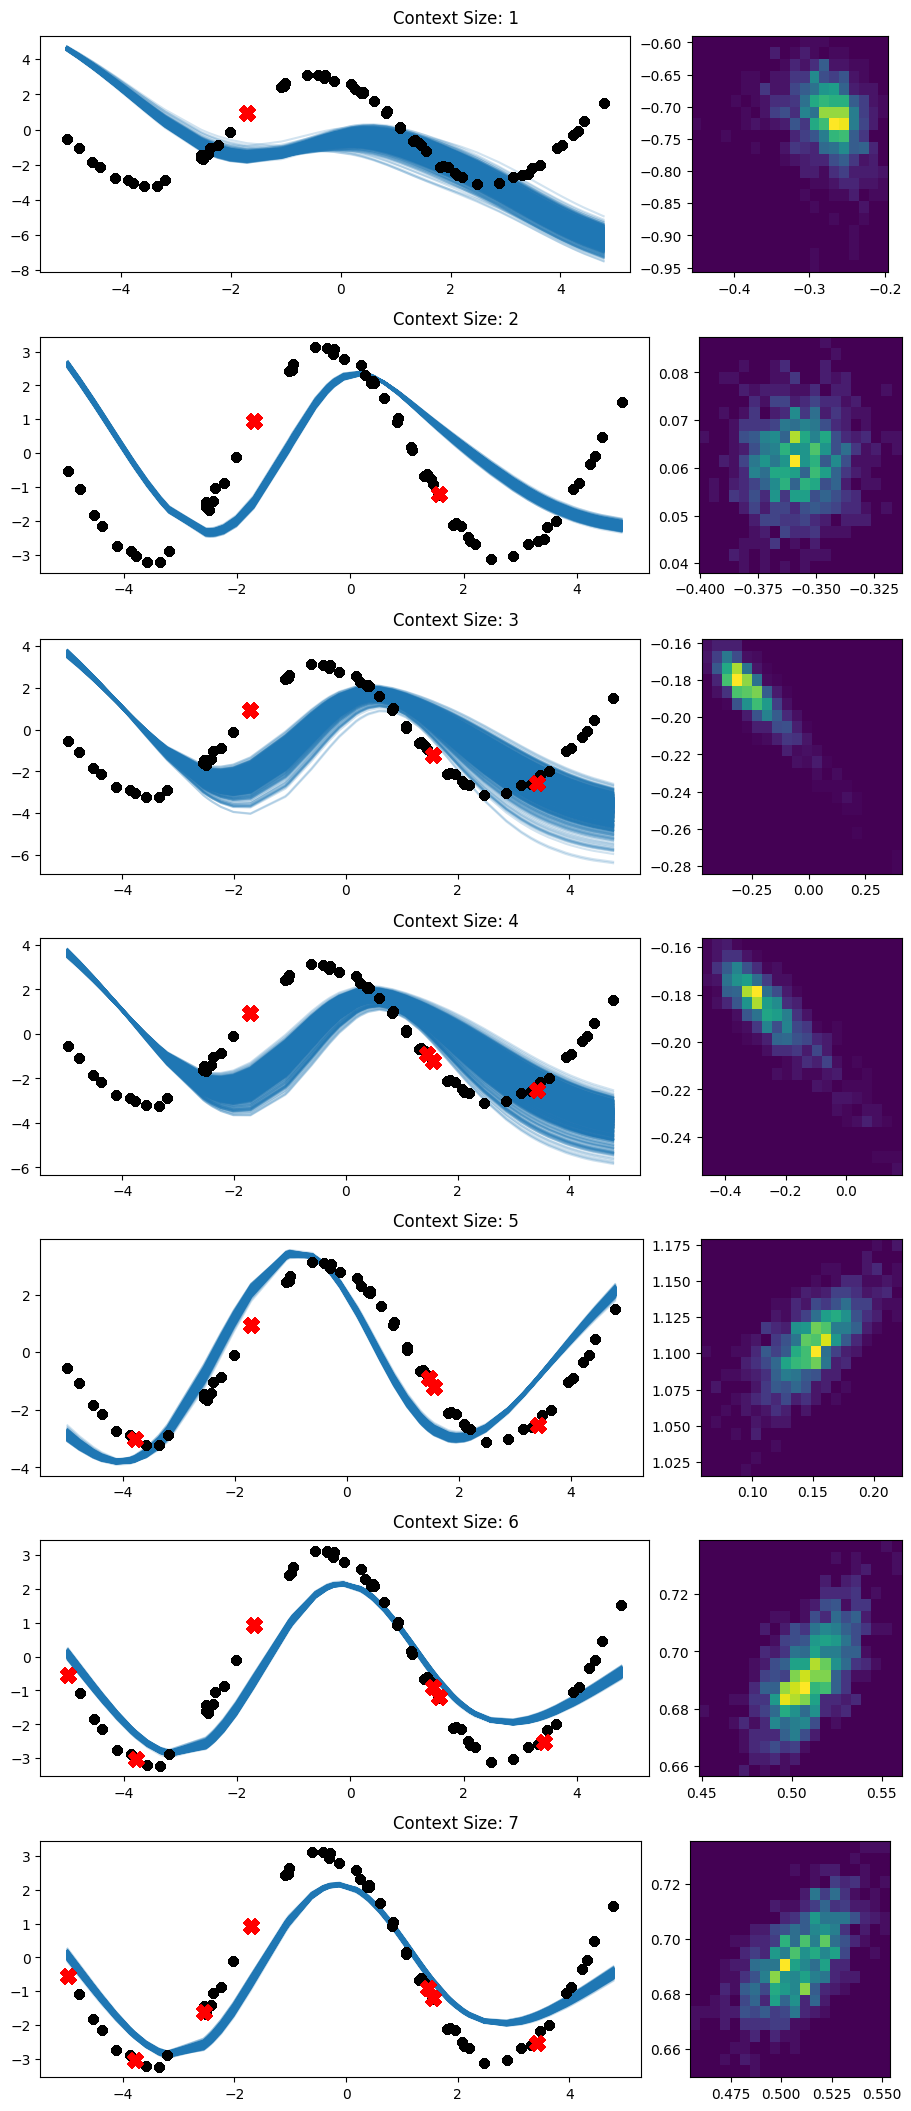

In [29]:
gen_dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)

max_context_size = 7
num_samples = config.batch_size

x_data, y_data = next(iter(gen_dataloader))
x_data, y_data = x_data.to(device), y_data.to(device)
x_data, y_data = x_data.expand(num_samples, -1, -1), y_data.expand(num_samples, -1, -1)

x_data_sorted, indices = x_data.sort(dim=1)
indices = indices[1].squeeze(1)
x_data_sorted = x_data_sorted.cpu().detach().numpy()
y_data_sorted = y_data[:, indices, :].cpu().detach().numpy()

fig = plt.figure(figsize=(9, 3 * max_context_size), constrained_layout=True)
subfigs = fig.subfigures(nrows=max_context_size, ncols=1)

for row, subfig in enumerate(subfigs):
    subfig.suptitle(f"Context Size: {row + 1}")
    ax = subfig.subplots(nrows=1, ncols=2, width_ratios=[3, 1])

    context_size = row + 1 # 3 # x_data.shape[1] #
    x_context = x_data[:, :context_size, :]
    y_context = y_data[:, :context_size, :]
    context = torch.cat([x_context, y_context], dim=-1)

    dvi_process.eval()
    # with torch.no_grad():

    aggregated, non_aggregated = set_encoder(context, None)

    p_z_T = LikelihoodTimesPrior(
        decoder=decoder,
        x_target=x_context,
        y_target=y_context,
        mask=None,
        context_embedding=non_aggregated if config.is_decoder_cross_attentive else aggregated,
    )
    
    _, z_samples = dvi_process.run_chain(p_z_T, non_aggregated if control_function.is_cross_attentive else aggregated, None)
    y_dist: Distribution = decoder(x_data, z_samples[-1], non_aggregated if control_function.is_cross_attentive else aggregated, None)

    y_mu_sorted = y_dist.mean[:, indices, :].cpu().detach().numpy()

    for k in range(num_samples):
        ax[0].plot(x_data_sorted[k].squeeze(1), y_mu_sorted[k].squeeze(1), alpha=0.2, c="tab:blue", zorder=0)

    ax[0].scatter(x_data_sorted, y_data_sorted, marker="o", c="black", zorder=1)
    ax[0].scatter(x_context.cpu().detach().numpy(), y_context.cpu().detach().numpy(), marker="X", c="red", s=100, zorder=2)

    ax[1].hist2d(z_samples[-1][:, 0].cpu().detach().numpy(), z_samples[-1][:, 1].cpu().detach().numpy(), bins=20)

plt.show()